# PCA

在这个任务中，我们首先会利用**PCA**将一个2D的数据集压缩到1D。\
熟悉了PCA后，我们还需要对5000张人脸图片进行PCA

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.io as sio

# PCA: 2D to 1D

## load data & visualize

In [47]:
mat = sio.loadmat('./data/ex7data1.mat')
X = mat.get('X')
X.shape

(50, 2)

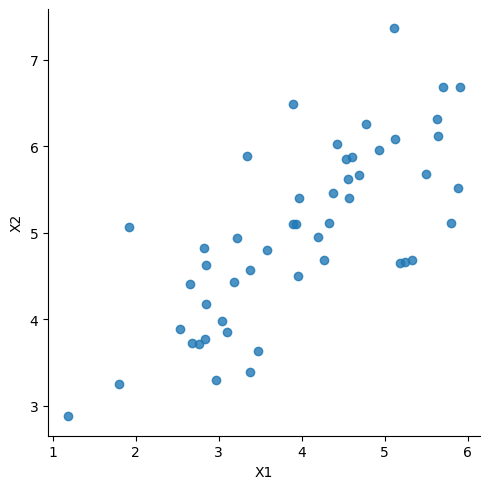

In [48]:
sns.lmplot(x='X1', y='X2', data=pd.DataFrame(X, columns=['X1', 'X2']), fit_reg=False)
plt.show()

## normalize feature

In [49]:
def normalize_feature(X):
    mean = X.mean(axis=0, keepdims=True)  # compute the mean column by column
    std = X.std(axis=0, keepdims=True)    # compute stderr, and keeps the dim
    return (X - mean) / std

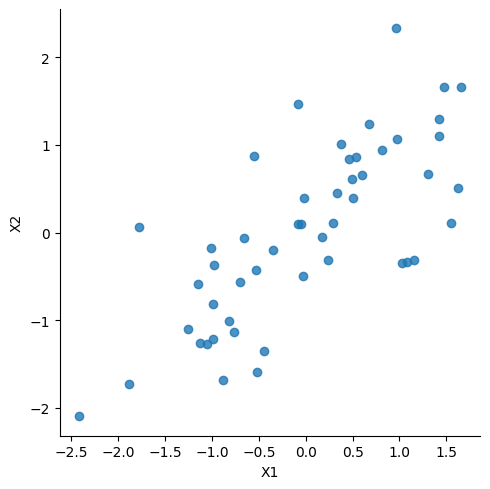

In [50]:
X_norm = normalize_feature(X)
sns.lmplot(x='X1', y='X2', data=pd.DataFrame(X_norm, columns=['X1', 'X2']), fit_reg=False)
plt.show()

## implement PCA

In [51]:
def convariance_matrix(X):
    m = X.shape[0]
    return (X.T @ X) / m

In [52]:
def PCA(X):
    """
    Args:
        X ndarray(m, n)
    Returns:
        U ndarray(n, n): principle components
    """
    
    X_norm = normalize_feature(X)
    Sigma = convariance_matrix(X_norm)
    U, S, V = np.linalg.svd(Sigma)
    
    return U, S, V

In [53]:
U, S, V = PCA(X)
U, S, V

(array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]),
 array([1.73553038, 0.26446962]),
 array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]))

## data projection

$Z^{(i)} = U^T x^{(i)}$\
$Z = XU$

In [54]:
def project_data(X, U, k):
    '''
    projected n dimention to k dimention
    '''
    m, n = X.shape
    if k > n:
        raise ValueError('k should be lower dimension of n')
    
    return X @ U[:, :k]

In [55]:
Z = project_data(X_norm, U, 1)
Z[:10]

array([[ 1.49631261],
       [-0.92218067],
       [ 1.22439232],
       [ 1.64386173],
       [ 1.2732206 ],
       [-0.97681976],
       [ 1.26881187],
       [-2.34148278],
       [-0.02999141],
       [-0.78171789]])

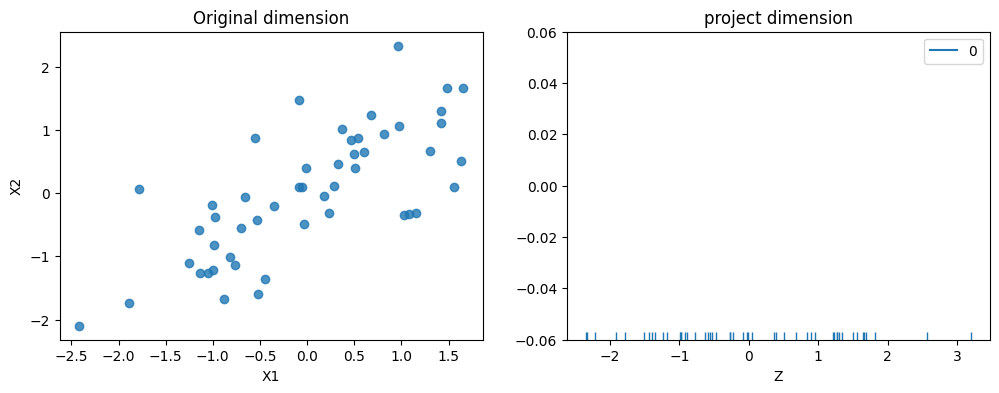

In [56]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
sns.regplot(x='X1', y='X2', data=pd.DataFrame(X_norm, columns=['X1', 'X2']), 
            fit_reg=False, ax = ax1)
ax1.set_title('Original dimension')

sns.rugplot(Z, ax=ax2)
ax2.set_xlabel('Z')
ax2.set_title('project dimension')
plt.show()

## recover data

$U$是正交矩阵，有$U^{-1} = U^T$\
故还原样本可以近似为：$x_{approx}^{(i)} = Uz^{(i)}$

In [57]:
def recover_data(Z, U):
    m, n = Z.shape
    if n >= U.shape[0]:
        raise ValueError('Z dimension is upper than U, you should recover lower dimension to higher')
    
    return Z @ U[:, :n].T

In [58]:
X_recover = recover_data(Z, U)
X_recover[:10]

array([[-1.05805279, -1.05805279],
       [ 0.65208021,  0.65208021],
       [-0.86577611, -0.86577611],
       [-1.16238578, -1.16238578],
       [-0.90030292, -0.90030292],
       [ 0.69071588,  0.69071588],
       [-0.89718548, -0.89718548],
       [ 1.65567835,  1.65567835],
       [ 0.02120713,  0.02120713],
       [ 0.55275802,  0.55275802]])

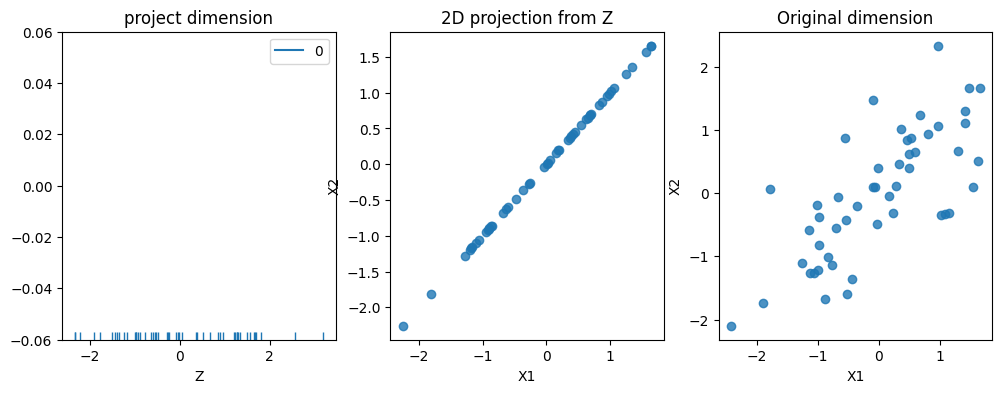

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,4))
sns.rugplot(Z, ax=ax1)
ax1.set_title('project dimension')
ax1.set_xlabel('Z')

sns.regplot(x='X1', y='X2', data=pd.DataFrame(X_recover, columns=['X1', 'X2']),
           fit_reg=False, ax=ax2)
ax2.set_title('2D projection from Z')

sns.regplot(x='X1', y='X2', data=pd.DataFrame(X_norm, columns=['X1', 'X2']),
           fit_reg=False, ax=ax3)
ax3.set_title('Original dimension')

plt.show()

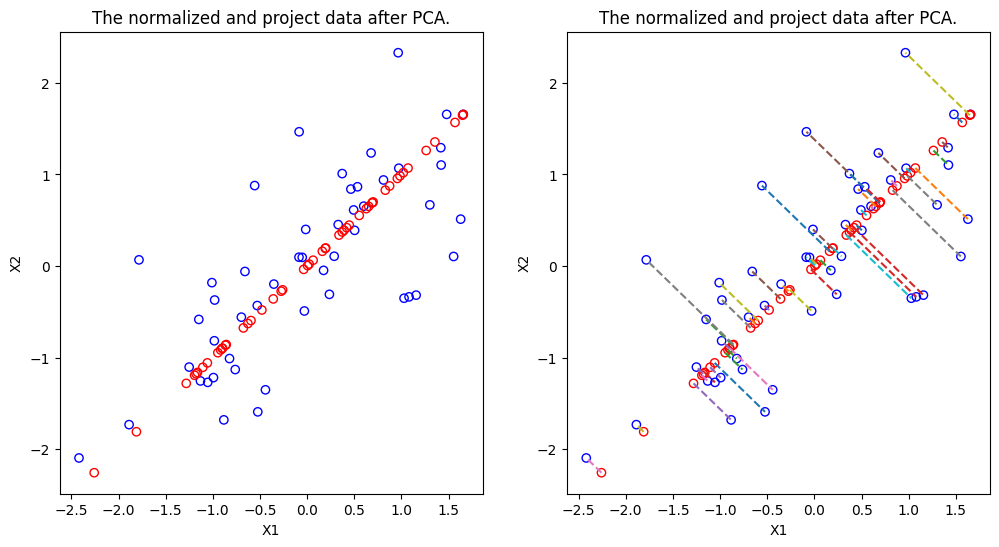

In [63]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))

ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_title('The normalized and project data after PCA.')
ax1.scatter(x=X_norm[:, 0], y=X_norm[:, 1], c='none', edgecolors='b')
ax1.scatter(x=X_recover[:, 0], y=X_recover[:, 1], c='none', edgecolors='r')

ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_title('The normalized and project data after PCA.')
ax2.scatter(x=X_norm[:, 0], y=X_norm[:, 1], c='none', edgecolors='b')
ax2.scatter(x=X_recover[:, 0], y=X_recover[:, 1], c='none', edgecolors='r')
ax2.plot([X_recover[:,0], X_norm[:,0]], [X_recover[:,1], X_norm[:,1]], '--')

plt.show()

# PCA: face data

接下来我们要对人脸图像进行PCA，每一张图片都是$32 \times 32$的灰度图

## load data & visualize

In [64]:
mat = sio.loadmat('./data/ex7faces.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [68]:
X = np.array([x.reshape((32,32)).T.reshape(1024) for x in mat.get('X')])
X.shape

(5000, 1024)

1024 features

In [75]:
# plot the first n images in 'X'
def plot_n_image(X, n):
    '''
    n must to be a square number
    '''
    pic_sz = int(np.sqrt(X.shape[1]))
    grid_sz = int(np.sqrt(n))
    
    images = X[:n, :]
    fig, ax_arrs = plt.subplots(nrows=grid_sz, ncols=grid_sz, 
                               sharey=True, sharex=True, figsize=(6, 6))
    
    for r in range(grid_sz):
        for c in range(grid_sz):
            ax_arrs[r, c].imshow(images[r*grid_sz + c].reshape((pic_sz, pic_sz)), cmap='gray')
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))            
    
    plt.show()

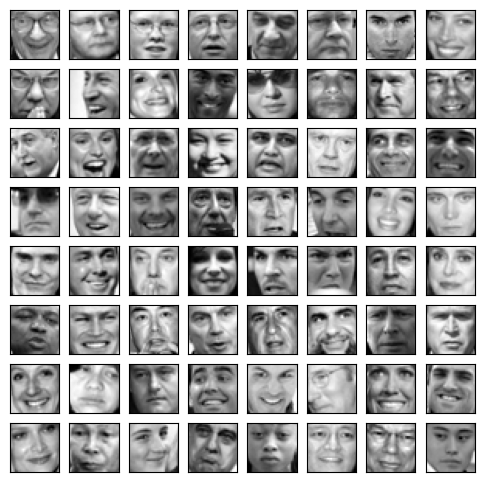

In [76]:
plot_n_image(X, n=64)

## run PCA

In [77]:
U, S, V = PCA(X)
U.shape

(1024, 1024)

## try $k=100$, reduce dimension & recover picture

In [79]:
Z = project_data(X, U, k=100)
Z.shape

(5000, 100)

In [81]:
X_recover = recover_data(Z, U)
X_recover.shape

(5000, 1024)

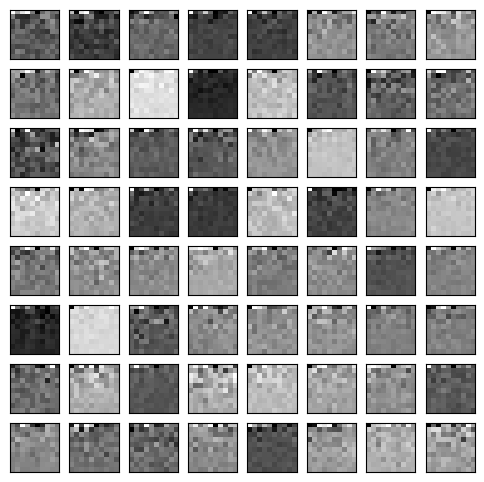

In [82]:
plot_n_image(Z, n=64)

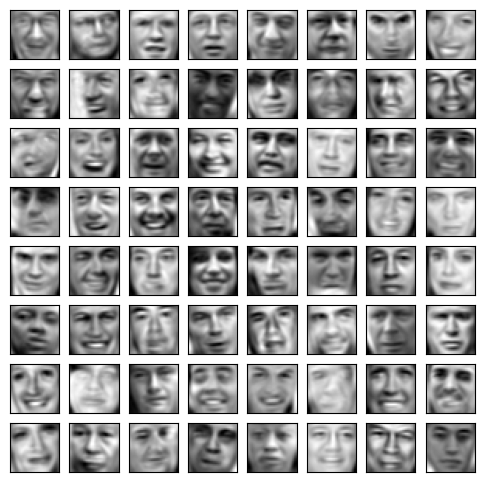

In [83]:
plot_n_image(X_recover, n=64)

## try $k=16$

In [86]:
Z = project_data(X, U, k=16)
X_recover = recover_data(Z, U)

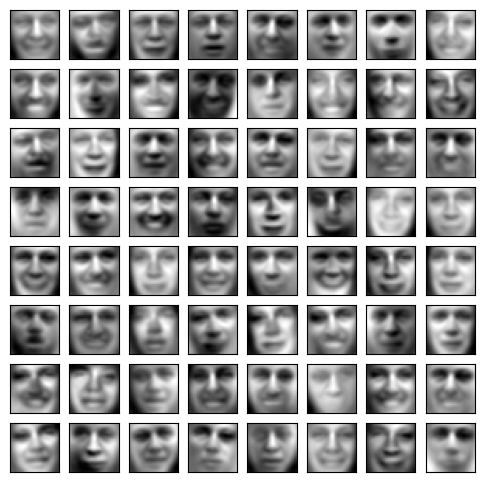

In [87]:
plot_n_image(X_recover, n=64)